In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
cabbage_df = pd.read_excel("data-files/양배추_가격_2.xlsx", engine='openpyxl')

In [108]:
cabbage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21414 entries, 0 to 21413
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       21414 non-null  object 
 1   거래단위       21414 non-null  object 
 2   총거래금액      21414 non-null  int64  
 3   도매시장       21414 non-null  object 
 4   도매법인       21414 non-null  object 
 5   품목         21414 non-null  object 
 6   품종         21414 non-null  object 
 7   산지-광역시도    21414 non-null  object 
 8   산지-시군구     21414 non-null  object 
 9   등급         21414 non-null  object 
 10  단위_무게(kg)  21414 non-null  int64  
 11  1kg_물량     21414 non-null  int64  
 12  1kg_평균가격   21414 non-null  float64
dtypes: float64(1), int64(3), object(9)
memory usage: 2.1+ MB


# DATE 피처 타입 변경

In [109]:
cabbage_df['DATE'] = pd.to_datetime(cabbage_df['DATE'], format='%Y-%m')

# 도매시장 피처 확인

In [110]:
cabbage_df['도매시장'].unique()

array(['서울가락도매', '인천삼산도매', '안산도매시장', '춘천도매시장', '대구북부도매', '부산반여도매',
       '강릉도매시장', '충주도매시장', '포항도매시장', '광주서부도매', '안양도매시장', '순천도매시장',
       '청주도매시장', '창원내서도매시장', '인천구월도매', '울산도매시장', '원주도매시장', '광주각화도매',
       '창원팔용도매시장', '전주도매시장', '구리도매시장', '수원도매시장', '부산엄궁도매', '구미도매시장',
       '서울강서도매', '진주도매시장', '천안도매시장', '대전오정도매', '정읍도매시장', '대전노은도매',
       '익산도매시장', '안동도매시장'], dtype=object)

# 산지-광역시도 피처 확인

In [111]:
cabbage_df['산지-광역시도'].unique()

array(['충청남도', '전라남도', '강원도', '경상북도', '충남', '전남', '서울', '전라북도', '중국',
       '경기도', '대구광역시', '제주도', '부산', '강원', '부산광역시', '-', '서울특별시', '충청북도',
       '경상남도', '인천', '충북', '경북', '전북', '경남', '제주', '경기', '인천광역시', '울산광역시',
       '대구', '광주광역시', '광주', '울산', '대전광역시', '대전', '뉴질랜드', '수입산'],
      dtype=object)

# 산지-광역시도 전처리 (충남 = 충청남도와 같이)

In [112]:
# 산지-광역시도 기준 디렉토리

region_sum = {
    '충남': '충청남도', 
    '강원': '강원도', 
    '제주':'제주도', 
    '전남' : '전라남도',
    '전북' : '전라북도', 
    '강원' : '강원도',
    '충북' : '충청북도',
    '부산' : '부산광역시',
    '경남' : '경상남도',
    '서울' : '서울특별시',
    '광주' : '광주광역시', 
    '경북' : '경상북도',
    '경기' : '경기도',
    '인천' : '인천광역시',
    '대구' : '대구광역시',
    '울산' : '울산광역시',
    '대전' : '대전광역시'
}

In [113]:
# 산지-광역시도 데이터를 위에서 만든 기준 디렉토리를 이용하여 변경
# 충북 = 충청북도, 충남 = 충청남도 등

cabbage_df['산지-광역시도'] = cabbage_df['산지-광역시도'].replace(region_sum)

In [114]:
# 우리나라 지역이 아닌 곳들 제거
cabbage_df = cabbage_df[~cabbage_df['산지-광역시도'].isin(['뉴질랜드', '수입산', '중국','-'])]


In [115]:
cabbage_df.to_csv("data-files/cabbage_df.csv")

# 도매시장 데이터 전처리 ( 데이터 부족한 도매시장제거 )

In [116]:
# DATE 열을 datetime 형식으로 변환
cabbage_df['DATE'] = pd.to_datetime(cabbage_df['DATE'])

# 연도와 월 정보 추가
cabbage_df['Year'] = cabbage_df['DATE'].dt.year
cabbage_df['Month'] = cabbage_df['DATE'].dt.month

# 도매시장이 2020년 1월부터 2024년 10월 사이에 연도별 최소 6개월 데이터를 가지고 있는지 확인
def check_sufficient_data(market_data):
    """
    특정 도매시장이 2020년 1월부터 2024년 10월 사이에 연도별 최소 6개월 데이터를 가지고 있는지 확인.
    """
    for year, months in required_year_months.items():
        # 해당 연도의 월 데이터를 필터링
        months_with_data = [m for (y, m) in market_data if y == year]
        if len(months_with_data) < 6:  # 최소 6개월 데이터가 있어야 함
            return False
    return True

# 도매시장별 데이터 그룹화 및 필터링
grouped = cabbage_df.groupby(['도매시장', 'Year', 'Month']).size().reset_index()

# (Year, Month) 튜플 인덱스를 생성
grouped_data = grouped[['Year', 'Month']].apply(tuple, axis=1)

# 최소 6개월 조건을 만족하는 도매시장만 남기기
sufficient_markets = [
    market for market, data in grouped.groupby('도매시장')
    if check_sufficient_data(data[['Year', 'Month']].apply(tuple, axis=1))
]

# 최종 필터링된 데이터프레임 생성
filtered_df = cabbage_df[cabbage_df['도매시장'].isin(sufficient_markets)]

# 결과 확인
filtered_df.info(), len(sufficient_markets)


<class 'pandas.core.frame.DataFrame'>
Index: 20982 entries, 0 to 21413
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DATE       20982 non-null  datetime64[ns]
 1   거래단위       20982 non-null  object        
 2   총거래금액      20982 non-null  int64         
 3   도매시장       20982 non-null  object        
 4   도매법인       20982 non-null  object        
 5   품목         20982 non-null  object        
 6   품종         20982 non-null  object        
 7   산지-광역시도    20982 non-null  object        
 8   산지-시군구     20982 non-null  object        
 9   등급         20982 non-null  object        
 10  단위_무게(kg)  20982 non-null  int64         
 11  1kg_물량     20982 non-null  int64         
 12  1kg_평균가격   20982 non-null  float64       
 13  Year       20982 non-null  int32         
 14  Month      20982 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(3), object(8)
memory usage: 2.4+ MB


(None, 29)

# 시각화를 위해 도매시장별, 광역시도별로 그룹화

In [117]:
# 시각화 하기 위해서 1kg_평균가격, 1kg_물량, 도매시장, 산지-광역시도 컬럼만 가져오기

filtered_df['1kg_평균가격'] = pd.to_numeric(filtered_df['1kg_평균가격'], errors='coerce')
filtered_df['1kg_물량'] = pd.to_numeric(filtered_df['1kg_물량'], errors='coerce')


filtered_df_cleaned = filtered_df.dropna(subset=['1kg_평균가격', '1kg_물량', '도매시장', '산지-광역시도'])

# 가중치
filtered_df_cleaned['weighted_price'] = (
    filtered_df_cleaned['1kg_평균가격'] * filtered_df_cleaned['1kg_물량']
)


# 도매시장별로 그룹화
weighted_avg_market = (
    filtered_df_cleaned.groupby(['DATE', '도매시장']).apply(
        lambda g: g['weighted_price'].sum() / g['1kg_물량'].sum()
    ).reset_index(name='가중_평균가격')
)

# 광역시도별로 그룹화
weighted_avg_ragion = (
    filtered_df_cleaned.groupby(['DATE', '산지-광역시도'])
    .apply(lambda g: g['weighted_price'].sum() / g['1kg_물량'].sum())
    .reset_index(name='가중_평균가격')
)

C:\Users\human\AppData\Local\Temp\ipykernel_3372\2789896412.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['1kg_평균가격'] = pd.to_numeric(filtered_df['1kg_평균가격'], errors='coerce')
C:\Users\human\AppData\Local\Temp\ipykernel_3372\2789896412.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['1kg_물량'] = pd.to_numeric(filtered_df['1kg_물량'], errors='coerce')
C:\Users\human\AppData\Local\Temp\ipykernel_3372\2789896412.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the gr

# 도매시장별 월별 시각화

<Figure size 1400x800 with 0 Axes>

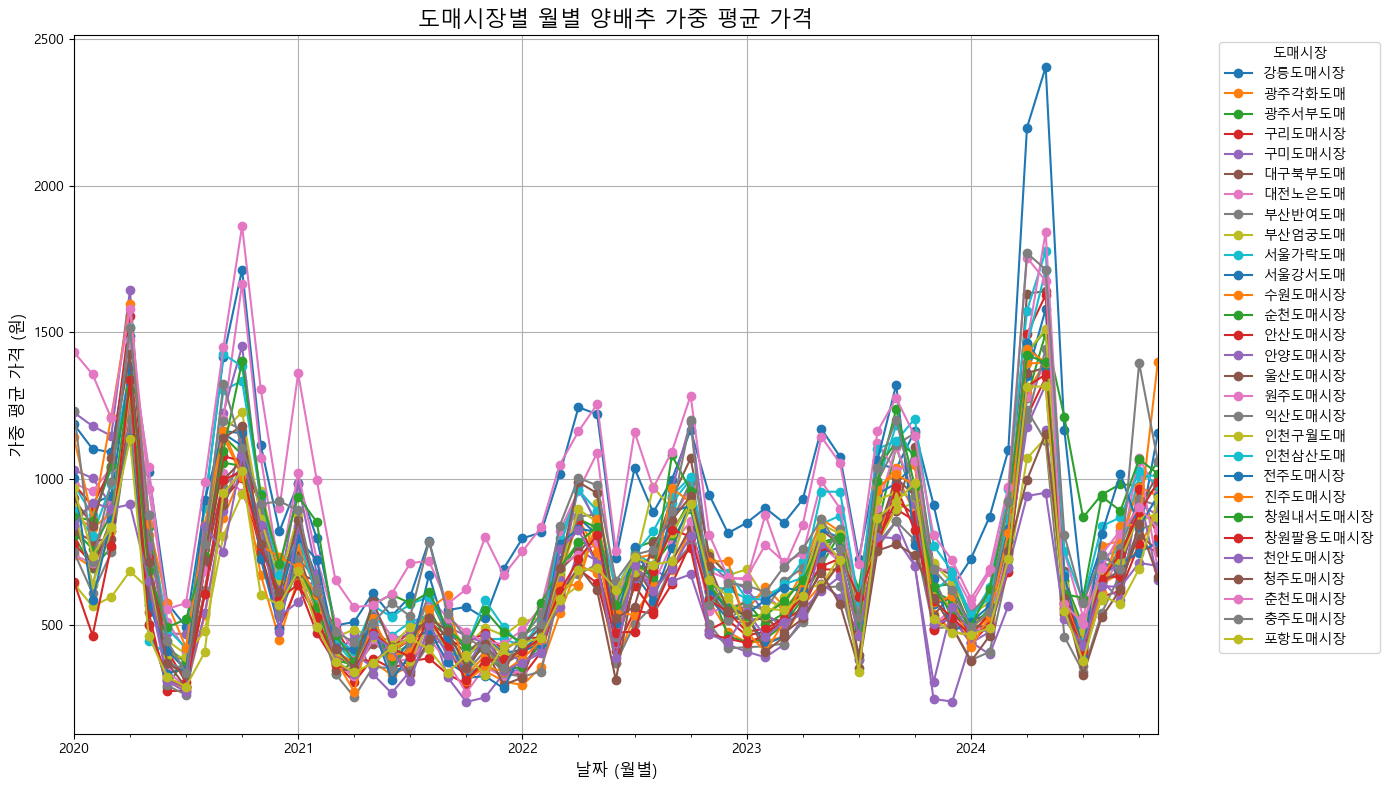

In [118]:
#도매시장별 월별 가격 시각화

import matplotlib.pyplot as plt

#한글
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False


cabbage_market_pivot = weighted_avg_market.pivot(index='DATE', columns='도매시장', values='가중_평균가격')

plt.figure(figsize=(14, 8))
cabbage_market_pivot.plot(kind='line', figsize=(14, 8), marker='o')

plt.title('도매시장별 월별 양배추 가중 평균 가격', fontsize=16)
plt.xlabel('날짜 (월별)', fontsize=12)
plt.ylabel('가중 평균 가격 (원)', fontsize=12)
plt.grid(True)
plt.legend(title='도매시장', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


# 광역시도별 월별 가격시각화

<Figure size 1400x800 with 0 Axes>

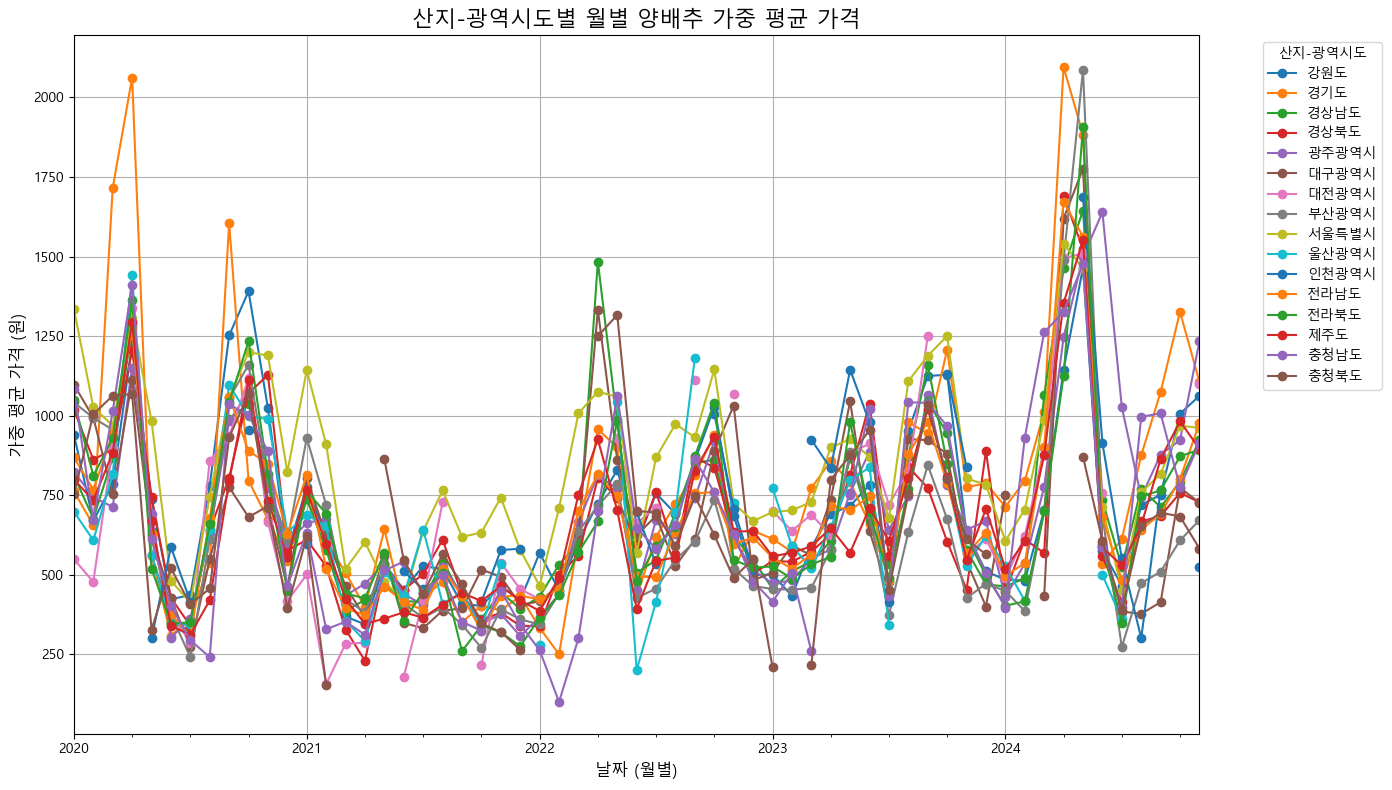

In [119]:
#광역시도별 월별 가격시각화

import matplotlib.pyplot as plt

#한글
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

weighted_avg_ragion = weighted_avg_ragion[weighted_avg_ragion['산지-광역시도'] != '-']

cabbage_ragion_pivot = weighted_avg_ragion.pivot(index='DATE', columns='산지-광역시도', values='가중_평균가격')

plt.figure(figsize=(14, 8))
cabbage_ragion_pivot.plot(kind='line', figsize=(14, 8), marker='o')

plt.title('산지-광역시도별 월별 양배추 가중 평균 가격', fontsize=16)
plt.xlabel('날짜 (월별)', fontsize=12)
plt.ylabel('가중 평균 가격 (원)', fontsize=12)
plt.grid(True)
plt.legend(title='산지-광역시도', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [120]:
# cabbage_df_cleaned.to_csv("data-files/cabbage_df_cleaned.csv", index=False)

# 기후데이터

In [121]:
# 기후 데이터 가져오기

weather_final = pd.read_csv("data-files/weather_final.csv")

In [122]:
weather_final

,광역시도,평균기온,평균풍속,평균강수량,DATE
0,강원도,-3.48,2.06,2.07,2019-01
1,강원도,-1.12,1.82,22.44,2019-02
2,강원도,4.30,2.18,41.57,2019-03
3,강원도,9.15,2.13,55.95,2019-04
4,강원도,16.84,2.24,18.88,2019-05
...,...,...,...,...,...
1193,충청북도,22.34,1.27,118.63,2024-06
1194,충청북도,25.83,1.41,449.82,2024-07
1195,충청북도,27.35,1.10,67.85,2024-08
1196,충청북도,23.90,1.08,233.70,2024-09


In [123]:
weather_final['DATE'] = pd.to_datetime(weather_final['DATE'], format='%Y-%m')

# 기후데이터와 양배추데이터 병합

In [124]:
merged_df = filtered_df.merge(
    weather_final,
    left_on=['DATE', '산지-광역시도'],
    right_on=['DATE', '광역시도'],
    how='left'
)

In [125]:
merged_df['DATE'] = merged_df['DATE'].dt.to_period('M').dt.to_timestamp()

# 필요없는 피처 제거( 사용하지 않는 피처 )

In [126]:
merged_df = merged_df.drop(columns=['총거래금액', '산지-시군구', '품목', '품종', '도매법인'])


In [127]:
merged_df = merged_df[~merged_df['DATE'].isin(['2024-11-01'])]

C:\Users\human\AppData\Local\Temp\ipykernel_3372\1813582411.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  merged_df = merged_df[~merged_df['DATE'].isin(['2024-11-01'])]


In [128]:
merged_df

,DATE,거래단위,도매시장,산지-광역시도,등급,단위_무게(kg),1kg_물량,1kg_평균가격,Year,Month,광역시도,평균기온,평균풍속,평균강수량
87,2024-10-01,8kg그물망,서울가락도매,강원도,특,8,22824192,1132.094998,2024,10,강원도,12.93,1.56,130.36
88,2024-10-01,8kg그물망,서울가락도매,충청남도,특,8,10377536,743.505125,2024,10,충청남도,16.32,2.29,92.38
89,2024-10-01,8kg그물망,서울가락도매,강원도,특,8,10340416,1248.230942,2024,10,강원도,12.93,1.56,130.36
90,2024-10-01,8kg그물망,서울가락도매,강원도,특,8,6676480,828.431629,2024,10,강원도,12.93,1.56,130.36
91,2024-10-01,8kg그물망,서울가락도매,강원도,특,8,6619776,990.455145,2024,10,강원도,12.93,1.56,130.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20977,2020-02-01,15kg상자,전주도매시장,전라북도,특,15,105750,393.333333,2020,2,전라북도,2.62,2.15,61.02
20978,2020-02-01,15kg상자,전주도매시장,전라북도,특,15,18000,920.000000,2020,2,전라북도,2.62,2.15,61.02
20979,2020-01-01,15kg상자,강릉도매시장,강원도,특,15,12150,325.308642,2020,1,강원도,-0.79,1.84,89.76
20980,2020-01-01,15kg상자,익산도매시장,전라북도,특,15,9000,640.000000,2020,1,전라북도,2.04,1.94,83.95


In [ ]:
# merged_df.to_csv("data-files/merged_df.csv", index = False)

# 상관관계 확인 (물량 - 기후)

In [130]:
# 각 재배 방식에 대한 파종 시기와 수확 시기 정의
cultivation_periods = {
    "봄재배": {"planting": [3, 4, 5], "harvesting": [6, 7]},
    "가을재배": {"planting": [7, 8], "harvesting": [10, 11]},
    "월동재배": {"planting": [9, 10], "harvesting": [3, 4, 5]},
    "여름재배": {"planting": [5, 6, 7], "harvesting": [9, 10]}
}

# 각 재배 방식에 대한 상관관계 결과를 저장할 딕셔너리
results = {}

for crop, periods in cultivation_periods.items():
    planting_months = periods['planting']  # 파종 시기 월 정의
    harvesting_months = periods['harvesting']  # 수확 시기 월 정의
    
    if crop == "월동재배":
        # 월동재배: 파종 시기는 현재 연도, 수확 시기는 다음 연도로 이동
        planting_climate_data = (
            merged_df[merged_df['DATE'].dt.month.isin(planting_months)]
            .groupby(merged_df['DATE'].dt.year)
            .mean(numeric_only=True)[['평균기온', '평균풍속', '평균강수량']]
            .rename_axis('YEAR')  # 연도를 인덱스로 사용
        )
        
        harvesting_transaction_data = (
            merged_df[merged_df['DATE'].dt.month.isin(harvesting_months)]
            .assign(YEAR=merged_df['DATE'].dt.year - 1)  # 수확 시기는 이전 연도의 데이터로 조정
            .groupby('YEAR')['1kg_물량']
            .sum()
            .rename_axis('YEAR')
        )
    else:
        # 다른 재배 방식: 기본 처리
        planting_climate_data = (
            merged_df[merged_df['DATE'].dt.month.isin(planting_months)]
            .groupby(merged_df['DATE'].dt.year)
            .mean(numeric_only=True)[['평균기온', '평균풍속', '평균강수량']]
            .rename_axis('YEAR')
        )
        
        harvesting_transaction_data = (
            merged_df[merged_df['DATE'].dt.month.isin(harvesting_months)]
            .groupby(merged_df['DATE'].dt.year)['1kg_물량']
            .sum()
            .rename_axis('YEAR')
        )
    
    # 상관관계 분석을 위해 데이터를 병합
    combined_analysis_data = planting_climate_data.merge(
        harvesting_transaction_data,
        left_index=True,
        right_index=True
    )
    
    # 상관관계 계산
    correlation_results = combined_analysis_data.corr().loc['1kg_물량'].drop('1kg_물량')
    results[crop] = correlation_results  # 결과 저장

# 결과를 하나의 데이터프레임으로 변환하여 표시
correlation_results_df = pd.DataFrame(results).transpose()

# 상관관계 결과 출력
correlation_results_df


,평균기온,평균풍속,평균강수량
봄재배,0.526839,-0.632086,0.286297
가을재배,-0.430676,-0.794214,0.333404
월동재배,-0.769999,0.856397,0.976336
여름재배,0.616197,0.833856,0.339667


# 상관관계 확인( 가격 - 물량)

In [131]:
import pandas as pd

# 각 재배 유형에 대한 상관관계 결과를 저장할 딕셔너리 생성
results = {}

# 재배 유형별로 순회하며 상관관계 계산
for crop, periods in cultivation_periods.items():
    planting_months = periods['planting']  # 파종기에 해당하는 월
    harvesting_months = periods['harvesting']  # 수확기에 해당하는 월
    
    # 파종기 데이터 집계
    planting_data = (
        merged_df[merged_df['DATE'].dt.month.isin(planting_months)]  # 파종기에 해당하는 데이터 필터링
        .groupby(merged_df['DATE'].dt.year)  # 연도별로 그룹화
        .mean(numeric_only=True)[['1kg_평균가격']]  # 1kg_ 가격 계산
        .rename_axis('YEAR')  # 인덱스를 연도로 설정
    )
    
    # 수확기 데이터 집계
    harvesting_data = (
        merged_df[merged_df['DATE'].dt.month.isin(harvesting_months)]  # 수확기에 해당하는 데이터 필터링
        .groupby(merged_df['DATE'].dt.year)['1kg_물량']  # 연도별로 그룹화 후 '1kg_물량' 합계 계산
        .sum()  # 총합 계산
        .rename_axis('YEAR')  # 인덱스를 연도로 설정
    )
    
    # 파종기 데이터와 수확기 데이터를 연도별로 병합
    combined_data = planting_data.merge(
        harvesting_data,
        left_index=True,  # 파종기 데이터의 연도를 기준으로 병합
        right_index=True  # 수확기 데이터의 연도를 기준으로 병합
    )
    
    # 상관관계 계산
    correlation_results = combined_data.corr().loc['1kg_물량'].drop('1kg_물량')  # '1kg_물량'과 다른 변수 간의 상관관계 계산
    results[crop] = correlation_results  # 결과를 해당 재배 유형에 저장

# 결과를 DataFrame으로 변환
correlation_results_df = pd.DataFrame(results).transpose()

In [132]:
correlation_results_df

,1kg_평균가격
봄재배,0.745671
가을재배,0.601320
월동재배,-0.535100
여름재배,0.875975


# 양배추 수입 데이터 확인

In [4]:
cabbage_import = pd.read_excel("data-files/양배추_수입.xlsx", engine='openpyxl')

In [5]:
cabbage_import

,DATE,구분,품목명,국가명,AGCODE,HSCODE,금액,중량
0,202410,수입,양배추,중화인민공화국,121020100,704901000,568861,1144525.00
1,202410,수입,양배추,중화인민공화국,121020400,712902060,320519,84010.00
2,202409,수입,양배추,중화인민공화국,121020100,704901000,249181,717160.00
3,202409,수입,양배추,중화인민공화국,121020400,712902060,403199,106692.00
4,202408,수입,양배추,중화인민공화국,121020100,704901000,235617,738300.00
...,...,...,...,...,...,...,...,...
223,202002,수입,양배추,중화인민공화국,121020400,712902060,321711,80460.00
224,202002,수입,양배추,타이,121020400,712902060,5,0.02
225,202001,수입,양배추,미국,121020100,704901000,28,2.73
226,202001,수입,양배추,중화인민공화국,121020100,704901000,1082004,4455579.00


# 월별 중량으로 그룹화 후 시각화 확인

In [6]:
# 월별 중량 그룹화
cabbage_import['DATE'] = pd.to_datetime(cabbage_import['DATE'], format='%Y%m')
monthly_weight = cabbage_import.groupby(cabbage_import['DATE'].dt.to_period('M'))['중량'].sum()

# 결과 확인
monthly_weight = monthly_weight.reset_index()
monthly_weight.columns = ['Month', 'Total_Weight']

In [7]:
monthly_weight

,Month,Total_Weight
0,2020-01,4573511.73
1,2020-02,2157252.82
2,2020-03,4101803.81
3,2020-04,8418120.00
4,2020-05,2640892.00
5,2020-06,793805.15
6,2020-07,454860.00
7,2020-08,1316323.00
8,2020-09,3105278.79
9,2020-10,5123622.63


C:\Users\human\AppData\Local\Temp\ipykernel_10356\373191416.py:11: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\human\AppData\Local\Temp\ipykernel_10356\373191416.py:11: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\human\AppData\Local\Temp\ipykernel_10356\373191416.py:11: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\human\AppData\Local\Temp\ipykernel_10356\373191416.py:11: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\human\AppData\Local\Temp\ipykernel_10356\373191416.py:11: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\human\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50900 (\N{HANGU

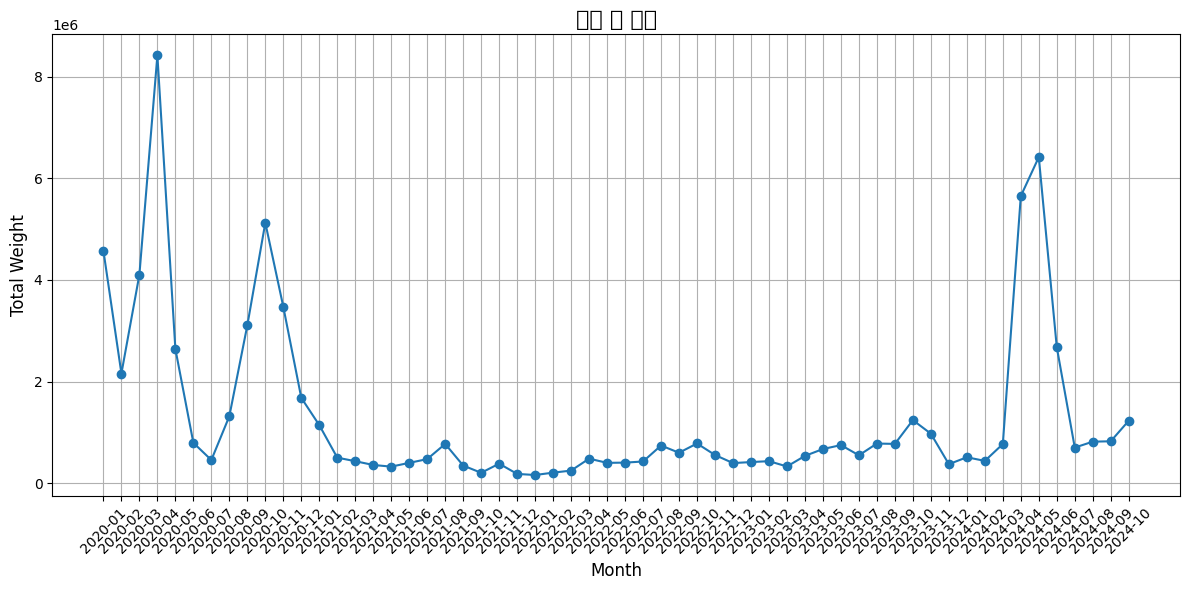

In [8]:
import matplotlib.pyplot as plt

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(monthly_weight['Month'].astype(str), monthly_weight['Total_Weight'], marker='o', linestyle='-')
plt.title('월별 총 중량', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Weight', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# 상관관계 확인

In [9]:
filtered_data = pd.read_csv('data-files/filtered_80_percent_confidence.csv')

# 날짜 열을 datetime 형식으로 변환
filtered_data['DATE'] = pd.to_datetime(filtered_data['DATE'])

# 월별 평균 가격 계산
filtered_data['Month'] = filtered_data['DATE'].dt.to_period('M')
monthly_avg_price = filtered_data.groupby('Month')['1kg_평균가격'].mean().reset_index()
monthly_avg_price.columns = ['Month', 'Average_Price']

# 기존 중량 데이터와 병합
correlation_data = pd.merge(monthly_weight, monthly_avg_price, on='Month', how='inner')

# 상관관계 확인
correlation = correlation_data[['Total_Weight', 'Average_Price']].corr()

In [11]:
correlation

,Total_Weight,Average_Price
Total_Weight,1.000000,0.660241
Average_Price,0.660241,1.000000


# 평균가격과 시각화하여 비교

C:\Users\human\AppData\Local\Temp\ipykernel_10356\398004743.py:20: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\human\AppData\Local\Temp\ipykernel_10356\398004743.py:20: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\human\AppData\Local\Temp\ipykernel_10356\398004743.py:20: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\human\AppData\Local\Temp\ipykernel_10356\398004743.py:20: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\human\AppData\Local\Temp\ipykernel_10356\398004743.py:20: UserWarning: Glyph 48143 (\N{HANGUL SYLLABLE MIC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\human\AppData\Local\Temp\ipykernel_10356\398004743.py:20: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing 

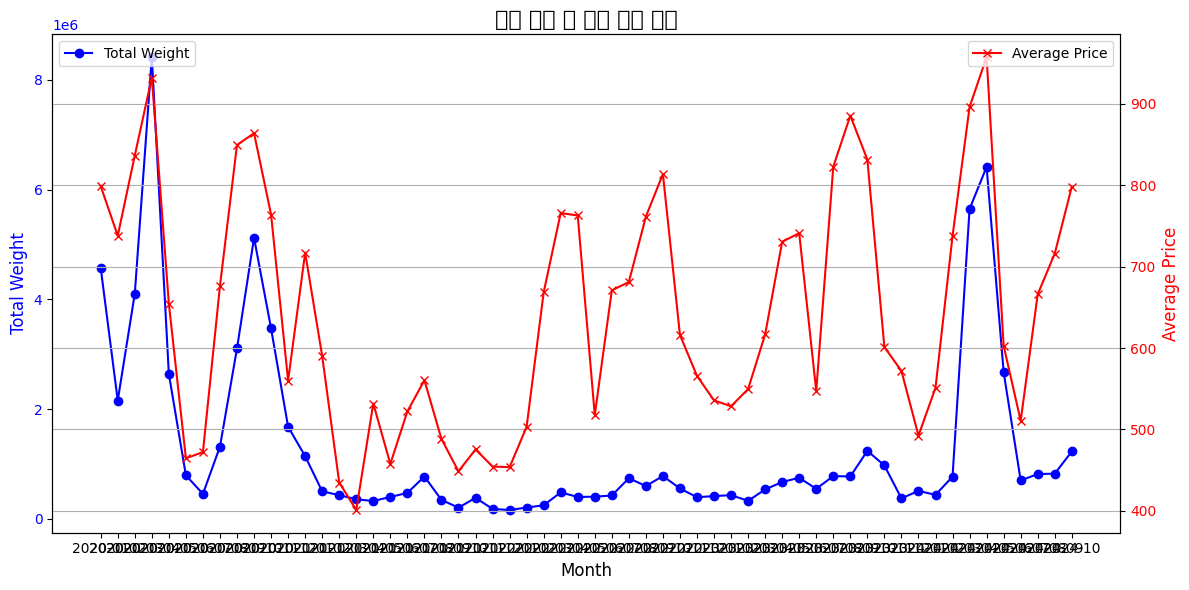

In [10]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# 중량 그래프
ax1.plot(correlation_data['Month'].astype(str), correlation_data['Total_Weight'], color='blue', marker='o', label='Total Weight')
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Total Weight', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# 평균 가격 그래프
ax2 = ax1.twinx()
ax2.plot(correlation_data['Month'].astype(str), correlation_data['Average_Price'], color='red', marker='x', label='Average Price')
ax2.set_ylabel('Average Price', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.title('월별 중량 및 평균 가격 변화', fontsize=16)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()